In [2]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/DIG_Stock.csv')
df1=df.reset_index()['Price']

In [157]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [158]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [159]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [160]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [161]:
# 8. Define LSTM Model

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
#
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [162]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0016 - val_loss: 0.1414
Epoch 2/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0015 - val_loss: 0.1625
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0014 - val_loss: 0.1868
Epoch 4/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0014 - val_loss: 0.1884
Epoch 5/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 0.1978
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 0.1919
Epoch 7/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.1969
Epoch 8/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.1951
Epoch 9/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.1965
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.1980

In [163]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [128]:
train_predict = train_predict.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)
y_pred_val = y_pred_val.reshape(-1,1)

In [114]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [129]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [118]:
ytest=ytest.reshape((-1,1))
yval =yval.reshape((-1,1))

In [164]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.10772291481098319
Testing RMSE: 0.45028055016472784


In [165]:
scaler.inverse_transform(test_rmse.reshape(-1,1))

array([[47839.70476978]])

In [166]:
valid_mape = np.mean(abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(abs((ytest - y_pred) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 73.52071968450284
Testing MAPE: 87.8914200563007


In [142]:
scaler.inverse_transform(test_mape.reshape(-1,1))

array([[7238629.38377125]])

In [103]:
x_input = val_data[60:].reshape(1, -1)
x_input = x_input.reshape((1, 79, 1))

predictions = []
for _ in range(30):
    yhat = model.predict(x_input, verbose=0)
    predictions.append(yhat[0][0])
    x_input = np.roll(x_input, -1)
    x_input[0][-1][0] = yhat[0][0]

print(predictions)

[array([0.05867614], dtype=float32), array([0.05864302], dtype=float32), array([0.05864137], dtype=float32), array([0.05861329], dtype=float32), array([0.05848116], dtype=float32), array([0.05855884], dtype=float32), array([0.0582874], dtype=float32), array([0.0582874], dtype=float32), array([0.05811131], dtype=float32), array([0.05827457], dtype=float32), array([0.05815212], dtype=float32), array([0.05820314], dtype=float32), array([0.05818273], dtype=float32), array([0.05812151], dtype=float32), array([0.0580807], dtype=float32), array([0.05795825], dtype=float32), array([0.05811131], dtype=float32), array([0.05816233], dtype=float32), array([0.05825416], dtype=float32), array([0.0581011], dtype=float32), array([0.05817253], dtype=float32), array([0.05821335], dtype=float32), array([0.05826437], dtype=float32), array([0.05833982], dtype=float32), array([0.05849411], dtype=float32), array([0.05839223], dtype=float32), array([0.05846822], dtype=float32), array([0.05839223], dtype=float

In [88]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:]
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 79
i = 0
while i < 30:
    if len(temp_input) > 79:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


AttributeError: ignored

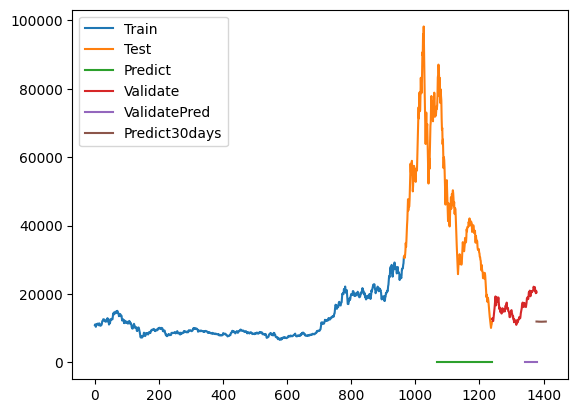

In [104]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred[:, 0]))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val[:, 0])
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(predictions))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()